In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [51]:
# initialize params
seed = 294

num_iters = 1
T = 5  # time horizon
n = 2  # num historical samples
delta = 0.3
alpha = 0 # percentage of time to pull arm 0
mean_arms = [.5, .5-delta]  # note: arm 0 always better
n_arms = len(mean_arms)

In [53]:
np.random.seed(seed)
regret_data = []

def generate_dataset(n, alpha):
    """ generate historical samples """
    dataset = {'0': [], '1': []}
    for _ in range(int(alpha*n)):
#         dataset['0'].append(np.random.binomial(p=mean_arms[0], n=1))
        dataset['0'].append(mean_arms[0])
    for _ in range(n - int(alpha*n)):
#         dataset['1'].append(np.random.binomial(p=mean_arms[1], n=1))
        dataset['1'].append(mean_arms[1])
    return dataset

def conf_r(t, n_pulls):
    """ compute confidence radius """
    return np.sqrt(2*np.log(1+t) / n_pulls)
#     return np.sqrt(2*np.log(1+T) / n_pulls)
    

online_use_all_data_count = 0.0
online_data_use_percentage = []

algo_list = ['simple', 'online']

# simple algorithm (Thorsten 2012)
# online algorithm: Christina's

for i in range(num_iters):
    
    dataset = generate_dataset(n, alpha)
    online_samples = generate_dataset(2*T, .5) # gets samples which are used for the "online" samples
    print(f'Dataset: {dataset}')
    # initialize counters
    online_data_index   = np.asarray([0,0]) # index of wrapper algorithm in historical samples
    online_regret_index = 0 # index of wrapper algorithm for using online samples
    
    regret = {}
    mean   = {}
    select = {}
    algo_index = {'simple': [0,0], 'no_history': [0,0], 'online': [0,0]} # index of algorithms in online samples
    
    for algo in algo_list:
        
        regret[algo] = 0
        mean[algo]   = np.asarray([0.0, 0.0])
        select[algo] = np.asarray([0, 0])
    
        mean['simple']   = np.asarray([max(0.0, np.mean(dataset['0'])), max(0.0, np.mean(dataset['1']))])
        select['simple'] = np.asarray([len(dataset['0']), len(dataset['1'])])
    
    for t in range(T+n):
        for algo in algo_list:   
            
            if np.sum(algo_index[algo]) < T: # not finished yet in the experiment
            
            # -----------------------------------
            # pick arm to pull
            # -----------------------------------
                ucb = np.asarray([mean[algo][arm] + conf_r(np.sum(algo_index[algo])+1, select[algo][arm]) \
                                      if select[algo][arm] > 0 else np.inf for arm in range(n_arms)])
                arm = np.argmax(ucb)
                if algo == 'simple':
                    print(f'Algo: {algo}, UCB: {ucb}, arm: {arm}')
                select[algo][arm] += 1

                if algo == 'online':
                    # if we haven't used all offline samples of the chosen arm
                    if online_data_index[arm] < len(dataset[str(arm)]):
                        print('using historical data')
                        obs = dataset[str(arm)][online_data_index[arm]]
                        mean[algo][arm] = (mean[algo][arm] * select[algo][arm] + obs) / (select[algo][arm]+1)
                        online_data_index[arm] += 1
                        continue
                    # if we HAVE used all offline samples of the chosen arm
                    else:
                        online_regret_index += 1
                        if algo == 'online': 
                            print(f'Algo: {algo}, UCB: {ucb}, arm: {arm}')

                # -----------------------------------
                # get observation and record
                # -----------------------------------
                regret[algo] += mean_arms[0] - mean_arms[arm]
                regret_data.append({'Algo': algo, 'Iter': i, 't': np.sum(algo_index[algo]), 'Arm': arm, 'Regret': regret[algo]})
                obs = online_samples[str(arm)][algo_index[algo][arm]]
                algo_index[algo][arm] += 1
                mean[algo][arm] = (mean[algo][arm]*select[algo][arm] + obs) / (select[algo][arm]+1)

            
    # meta trackers on behavior of online algorithm
    if online_data_index[0] == len(dataset['0']) and online_data_index[1] == len(dataset['1']):
        online_use_all_data_count += 1
    
    online_data_use_percentage.append((online_data_index[0] + online_data_index[1]) / n)

print('----------------------------')
print('Stats from online algorithm')
print(f'  # pulls of each arm in historical data:     {online_data_index}')
print(f'  Percentage of trials entire dataset used:   {100 * online_use_all_data_count / num_iters}')
print(f'  Average percentage of historical data used: {100*np.mean(online_data_use_percentage):.2f}')

Dataset: {'0': [], '1': [0.2, 0.2]}
Algo: simple, UCB: [       inf 1.03255461], arm: 0
Algo: online, UCB: [inf inf], arm: 0
Algo: simple, UCB: [1.73230381 1.24814707], arm: 0
using historical data
Algo: simple, UCB: [1.51074336 1.37741002], arm: 0
Algo: online, UCB: [1.73230381 1.58230381], arm: 0
Algo: simple, UCB: [1.41083715 1.46863624], arm: 1
using historical data
Algo: simple, UCB: [1.46793472 1.29293472], arm: 0
Algo: online, UCB: [1.51074336 1.31074336], arm: 0
Algo: online, UCB: [1.41083715 1.40196957], arm: 0
Algo: online, UCB: [1.34650924 1.47189953], arm: 1
----------------------------
Stats from online algorithm
  # pulls of each arm in historical data:     [0 2]
  Percentage of trials entire dataset used:   100.0
  Average percentage of historical data used: 100.00


<bound method NDFrame.tail of      Algo  Iter  t  Arm  Regret
0  simple     0  0    0     0.0
1  online     0  0    0     0.0
2  simple     0  1    0     0.0
3  simple     0  2    0     0.0
4  online     0  1    0     0.0
5  simple     0  3    1     0.3
6  simple     0  4    0     0.3
7  online     0  2    0     0.0
8  online     0  3    0     0.0
9  online     0  4    1     0.3>


Text(0.5, 1.0, 'n = 2, delta = 0.3, alpha = 0')

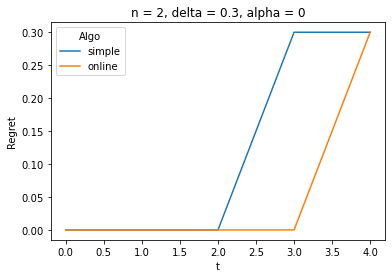

In [54]:
df = pd.DataFrame(regret_data)
print(df.tail)
p = sns.lineplot(data = df, x="t", y="Regret", hue="Algo", ci=None) #, ci="sd")
p.set_title(f"n = {n}, delta = {delta}, alpha = {alpha}") 
